In [1]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from torch.utils.data import DataLoader, Dataset

In [52]:
if torch.cuda.is_available(): 
    dev = "cuda:0"
else:
    dev = "cpu"
    
device = torch.device(dev)

In [53]:
device

device(type='cuda', index=0)

In [54]:
df = pd.read_csv("/kaggle/input/UNR-IDD/UNR-IDD.csv")

In [55]:
df = df.drop(columns = "Binary Label")

In [56]:
df.head()

,Switch ID,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,...,Unknown Load/Rate,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size,Label
0,of:000000000000000c,Port#:1,132,9181,6311853,238,46,0,0,0,...,0,0,0,True,0,9,767,688,-1,TCP-SYN
1,of:000000000000000c,Port#:2,187,6304498,15713,171,46,0,0,0,...,0,0,0,True,0,9,767,688,-1,TCP-SYN
2,of:000000000000000c,Port#:3,235,6311567,8030,58,46,0,0,0,...,0,0,0,True,0,9,767,688,-1,TCP-SYN
3,of:000000000000000c,Port#:4,59,7878,16439,182,46,0,0,0,...,0,0,0,True,0,9,767,688,-1,TCP-SYN
4,of:000000000000000a,Port#:1,188,6304547,16497,183,46,0,0,0,...,0,0,0,True,0,7,489,403,-1,TCP-SYN


In [57]:
len(df.Label.unique())

6

In [58]:
df.shape

(37411, 33)

In [59]:
df1 = df[(df.Label == "Diversion") | (df.Label == "Normal")].reset_index(drop = True)

In [60]:
len(df1.Label.unique())

2

In [61]:
df1.shape

(9388, 33)

In [62]:
df1.Label.value_counts()

Diversion    5615
Normal       3773
Name: Label, dtype: int64

In [63]:
df1 = df1.iloc[1842:]

In [64]:
def preprocessing(data): 
    le = LabelEncoder()
    ohe = OneHotEncoder(drop="first")
    scaler = MinMaxScaler()
    num_col = [val for val in data.columns if (data[val].dtype == 'int64')]
    data[num_col] = scaler.fit_transform(data[num_col])
    data["is_valid"] = le.fit_transform(data["is_valid"])
    data["Label"] = le.fit_transform(data["Label"])
    data = data.join(pd.DataFrame(ohe.fit_transform(data[["Switch ID", "Port Number"]]).toarray()))
    data = data.drop(columns = ["Switch ID", "Port Number"])
    return data

In [65]:
new_df = preprocessing(df1)

In [66]:
new_df.Label.value_counts()

0    3773
1    3773
Name: Label, dtype: int64

In [67]:
new_df.Label.unique()

array([0, 1])

In [68]:
n = new_df.shape[0]
np.random.seed(42)
idx = np.arange(n)
np.random.shuffle(idx)
new_df = new_df.iloc[idx]
new_df.reset_index(drop = True, inplace = True)

In [69]:
ohe = OneHotEncoder()
new_labels = ohe.fit_transform(new_df[["Label"]])

In [70]:
new_data = new_df.drop(columns = "Label")

In [71]:
new_data.shape, new_df.shape

((7546, 40), (7546, 41))

In [72]:
input_dim = new_df.shape[1]-1
output_dim = input_dim
num_classes = len(new_df.Label.unique())
#batch_size = 128
input_dim, output_dim, num_classes

(40, 40, 2)

In [73]:
# Define the generator
class IDSGenerator(nn.Module):
    def __init__(self, input_dim, num_classes, output_dim):
        super(IDSGenerator, self).__init__()
        self.fc1 = nn.Linear(102, 256)
        #self.fc2 = nn.Linear(256, 512)
        #self.fc3 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x, labels):
        if len(labels.shape) == 1:
            labels = labels.unsqueeze(-1)
        elif len(labels.shape) == 3:
            labels = labels.squeeze(dim = 1)
        x = torch.cat([x, labels], 1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = torch.tanh(self.fc2(x))
        return x

# Define the discriminator
class IDSDiscriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(IDSDiscriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim + num_classes, 256)
        #self.fc2 = nn.Linear(1024, 512)
        #self.fc3 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x, labels):
        if len(labels.shape) == 1:
            labels = labels.unsqueeze(-1)
        elif len(labels.shape) == 3:
            labels = labels.squeeze(dim = 1)
        labels = labels.float()
        x = torch.cat([x, labels], 1)
        x = F.leaky_relu(self.fc1(x))
        #x = F.leaky_relu(self.fc2(x))
        #x = F.leaky_relu(self.fc3(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Define the IDS model
class IDSModel(nn.Module):
    def __init__(self, input_dim, num_classes, output_dim):
        super(IDSModel, self).__init__()
        self.generator = IDSGenerator(input_dim, num_classes, output_dim)
        self.discriminator = IDSDiscriminator(input_dim, num_classes)

    def forward(self, x, labels=None): 
        #gen_output = self.generator(x)
        #disc_real_output = self.discriminator(x)
        #disc_fake_output = self.discriminator(gen_output)
        #return disc_real_output, disc_fake_output, gen_output
        if self.training: 
            # In training mode, we pass the labels to both generator and discriminator
            z = torch.randn(x.size(0), input_dim)
            gen_labels = torch.randint(0, num_classes, (x.size(0),))
            gen_data = self.generator(z, gen_labels)
            disc_scores = self.discriminator(x, labels)
            gen_scores = self.discriminator(gen_data, gen_labels)
            return disc_scores, gen_scores
        else:
            # In evaluation mode, we only generate data, so we only need labels for the generator
            gen_data = self.generator(x, labels)
            return gen_data


In [74]:
class MyDataset(Dataset):
    def __init__(self, dataframe, labels):
        self.dataframe = dataframe
        self.labels = labels

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        #features = torch.tensor(new_df.drop(columns = "Label").iloc[index].values, device = self.device).float()
        self.dataframe = self.dataframe.apply(pd.to_numeric, errors='coerce')
        features = torch.from_numpy(self.dataframe.iloc[index].values).float()
        #label = torch.tensor(self.dataframe.iloc[index]["Label"], device = self.device).float()
        labels = torch.from_numpy(self.labels[index].toarray())
        return features, labels

In [75]:
new_data[[val for val in new_data.columns if type(val) != str]] = new_data[[val for val in new_data.columns if type(val) != str]].fillna(new_data[[val for val in new_data.columns if type(val) != str]].median())

In [76]:
new_data

,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,Packets Tx Errors,Delta Received Packets,...,0,1,2,3,4,5,6,7,8,9
0,0.009227,0.209556,0.132499,0.006193,0.440965,0.0,0.0,0.0,0.0,0.263473,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.012536,0.233205,0.211947,0.008938,0.796117,0.0,0.0,0.0,0.0,0.023952,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.006512,0.162736,0.332483,0.983834,0.383025,0.0,0.0,0.0,0.0,0.604790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.997460,0.147799,0.380557,0.509762,0.736925,0.0,0.0,0.0,0.0,0.023952,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.010809,0.325252,0.343817,0.012405,0.752584,0.0,0.0,0.0,0.0,0.724551,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7541,0.889012,0.071702,0.107921,0.745353,0.226433,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7542,0.866710,0.094214,0.630518,0.683489,0.736925,0.0,0.0,0.0,0.0,0.023952,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7543,0.016793,0.580628,0.441993,0.981784,0.768243,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7544,0.000388,0.000034,0.026353,0.000465,0.000000,0.0,0.0,0.0,0.0,0.425150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [77]:
new_data.isna().sum()

Received Packets                 0
Received Bytes                   0
Sent Bytes                       0
Sent Packets                     0
Port alive Duration (S)          0
Packets Rx Dropped               0
Packets Tx Dropped               0
Packets Rx Errors                0
Packets Tx Errors                0
Delta Received Packets           0
Delta Received Bytes             0
Delta Sent Bytes                 0
Delta Sent Packets               0
Delta Port alive Duration (S)    0
Delta Packets Rx Dropped         0
 Delta Packets Tx Dropped        0
Delta Packets Rx Errors          0
Delta Packets Tx Errors          0
Connection Point                 0
Total Load/Rate                  0
Total Load/Latest                0
Unknown Load/Rate                0
Unknown Load/Latest              0
Latest bytes counter             0
is_valid                         0
Table ID                         0
Active Flow Entries              0
Packets Looked Up                0
Packets Matched     

In [78]:
dataset = MyDataset(new_data, new_labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle = True)

In [79]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [80]:
# Initialize the models
#generator = IDSGenerator()
#discriminator = IDSDiscriminator()
#model = IDSModel(generator, discriminator)
model = IDSModel(input_dim, num_classes, output_dim)
model = model.to(device).float()

# Define loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(model.generator.parameters(), lr=0.0001)
optimizer_D = torch.optim.Adam(model.discriminator.parameters(), lr=0.0001)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Set the number of epochs
n_epochs = 100
z_dim = 100

# Training loop
for epoch in range(n_epochs):
    for i, (data, labels) in enumerate(dataloader):
        data, labels = data.to(device), labels.to(device)  # move data and labels to device
        batch_size = len(data)
        #real_labels = torch.ones((batch_size, 1)).to(device)
        #fake_labels = torch.zeros((batch_size, 1)).to(device)
        
        # Train the discriminator
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, z_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device).float()  
        gen_labels_one_hot = F.one_hot(gen_labels.to(torch.int64), num_classes=2)    
        gen_data = model.generator(z, gen_labels_one_hot)
        real_scores = model.discriminator(data, labels)
        fake_scores = model.discriminator(gen_data.detach(), gen_labels_one_hot)
        d_loss = -torch.mean(real_scores) + torch.mean(fake_scores)
        d_loss.backward()
        optimizer_D.step()
        for p in model.discriminator.parameters(): p.data.clamp_(-0.01, 0.01)
            
        # Train the generator 
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, z_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device).float()
        gen_labels_one_hot = F.one_hot(gen_labels.to(torch.int64), num_classes = 2)
        gen_data = model.generator(z, gen_labels_one_hot)
        fake_scores = model.discriminator(gen_data, gen_labels_one_hot)
        g_loss = -torch.mean(fake_scores)
        g_loss.backward()
        optimizer_G.step()
        
        #real_scores = model.discriminator(data, labels)
        #d_loss_real = criterion(real_scores, real_labels)
        #fake_scores = model.discriminator(gen_data.detach(), gen_labels_one_hot)
        #d_loss_fake = criterion(fake_scores, fake_labels)
        #d_loss = d_loss_real + d_loss_fake
        #d_loss.backward()
        #optimizer_D.step()
        
        # Train the generator
        #optimizer_G.zero_grad()
        #z = torch.randn(batch_size, z_dim).to(device)
        #gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device).float()  # generate random labels for generator
        #gen_labels_one_hot = F.one_hot(gen_labels.to(torch.int64), num_classes=2)    # Get a one-hot tensor of size ([128, 2])
        #gen_data = model.generator(z, gen_labels_one_hot)
        #gen_scores = model.discriminator(gen_data, gen_labels_one_hot)
        #g_loss = criterion(gen_scores, real_labels)
        #g_loss.backward()
        #optimizer_G.step()

    # Print losses for every epoch
    print(f'Epoch {epoch+1}/{n_epochs}:\tDiscriminator Loss: {d_loss}\t\tGenerator Loss: {g_loss}')

Epoch 1/100:	Discriminator Loss: -0.006105989217758179		Generator Loss: -0.49659305810928345
Epoch 2/100:	Discriminator Loss: -0.0012176036834716797		Generator Loss: -0.5018243789672852
Epoch 3/100:	Discriminator Loss: -0.0015788674354553223		Generator Loss: -0.5011132955551147
Epoch 4/100:	Discriminator Loss: -0.0017507076263427734		Generator Loss: -0.5020782351493835
Epoch 5/100:	Discriminator Loss: -0.0038729608058929443		Generator Loss: -0.4991409182548523
Epoch 6/100:	Discriminator Loss: -0.001195669174194336		Generator Loss: -0.49960872530937195
Epoch 7/100:	Discriminator Loss: 0.0005388855934143066		Generator Loss: -0.5022485256195068
Epoch 8/100:	Discriminator Loss: 0.001846611499786377		Generator Loss: -0.5022285580635071
Epoch 9/100:	Discriminator Loss: -0.0016911625862121582		Generator Loss: -0.4974249601364136
Epoch 10/100:	Discriminator Loss: -0.001763850450515747		Generator Loss: -0.49796774983406067
Epoch 11/100:	Discriminator Loss: -0.0005200207233428955		Generator Loss

In [81]:
num_samples = 1000  # specify the number of samples you want
noise_dim = 100  # the dimension of the input noise vector, adjust according to your model
noise = torch.randn(num_samples, noise_dim).to(device)
labels = torch.randint(0, num_classes, (num_samples, )).float().to(device)
#labels = labels.float().unsqueeze(1).to(device)
labels_onehot = F.one_hot(labels.to(torch.int64), num_classes=2).float()
#inputs = torch.cat((noise,labels), -1)

with torch.no_grad():  # we don't need gradients for this part
    synthetic_data = model.generator(noise, labels_onehot)
    
synthetic_data = synthetic_data.cpu().numpy()  # move data to cpu and convert to numpy array
synthetic_df = pd.DataFrame(synthetic_data)  # convert to DataFrame

In [82]:
F.one_hot(labels.to(torch.int64), num_classes = 2).float()

tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        ...,
        [0., 1.],
        [0., 1.],
        [1., 0.]], device='cuda:0')

In [83]:
test1 = pd.DataFrame(torch.cat((model.generator(noise, labels_onehot), labels_onehot), -1).cpu().detach().numpy())

In [84]:
labels

tensor([1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
        1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0.,
        0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
        1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
        0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 

In [85]:
test1

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.537974,0.135781,0.156351,0.574102,0.533220,-0.158636,-0.101433,-0.032645,-0.105989,-0.063549,...,0.047417,-0.149233,-0.432112,0.144402,0.430720,0.462198,0.039850,0.225659,0.0,1.0
1,-0.004974,0.196055,0.178136,0.169558,0.453874,-0.018763,-0.040355,0.012371,-0.003687,-0.051264,...,0.267803,-0.022550,0.261758,0.067600,0.342194,0.498299,-0.174735,0.262961,1.0,0.0
2,0.498937,0.402633,0.405978,0.595868,0.717451,-0.152932,-0.158300,-0.043406,-0.252996,-0.062804,...,0.362044,0.077862,0.012036,0.035554,0.371593,0.464975,-0.085389,0.151620,0.0,1.0
3,0.176377,0.066691,0.175304,0.460799,0.465094,-0.012672,0.098899,0.090992,0.015092,-0.038908,...,0.044669,-0.056171,0.157613,0.074912,-0.193162,-0.035965,0.159661,0.245726,0.0,1.0
4,-0.088944,0.163707,0.152545,-0.121473,0.397098,-0.021557,0.087762,0.077328,0.053831,0.060876,...,0.332996,-0.046965,0.193844,-0.001762,0.387252,0.351752,0.175914,-0.013901,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.648247,0.441736,0.216079,0.641411,0.700321,0.092613,0.160054,0.050411,0.083747,0.334964,...,0.359591,-0.136777,0.515093,0.154892,0.330730,0.593833,0.009254,-0.097751,0.0,1.0
996,0.087570,0.141916,0.069388,-0.145960,0.415810,-0.028320,-0.122977,0.023025,-0.050155,0.104348,...,0.269484,-0.066122,0.412675,0.342117,-0.363268,0.547810,0.072129,0.068804,1.0,0.0
997,0.689149,0.576419,0.431294,0.793375,0.794358,0.135369,0.097210,0.124003,-0.053644,-0.115828,...,0.535664,-0.074024,0.086301,0.294766,-0.107924,0.613103,-0.290295,0.087478,0.0,1.0
998,0.242202,0.242578,0.245547,0.525288,0.384736,0.007170,-0.034059,0.000674,0.036789,0.092761,...,0.015867,-0.076312,0.091667,0.007711,0.081280,0.016797,-0.068244,0.204852,0.0,1.0


In [86]:
test1["label"] = test1[[40, 41]].apply(lambda x: x.idxmax() - 40, axis = 1)

In [87]:
test1.drop(columns = [40, 41], inplace = True)

In [88]:
test1

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,label
0,0.537974,0.135781,0.156351,0.574102,0.533220,-0.158636,-0.101433,-0.032645,-0.105989,-0.063549,...,0.520521,0.047417,-0.149233,-0.432112,0.144402,0.430720,0.462198,0.039850,0.225659,1
1,-0.004974,0.196055,0.178136,0.169558,0.453874,-0.018763,-0.040355,0.012371,-0.003687,-0.051264,...,-0.237409,0.267803,-0.022550,0.261758,0.067600,0.342194,0.498299,-0.174735,0.262961,0
2,0.498937,0.402633,0.405978,0.595868,0.717451,-0.152932,-0.158300,-0.043406,-0.252996,-0.062804,...,-0.070015,0.362044,0.077862,0.012036,0.035554,0.371593,0.464975,-0.085389,0.151620,1
3,0.176377,0.066691,0.175304,0.460799,0.465094,-0.012672,0.098899,0.090992,0.015092,-0.038908,...,0.456167,0.044669,-0.056171,0.157613,0.074912,-0.193162,-0.035965,0.159661,0.245726,1
4,-0.088944,0.163707,0.152545,-0.121473,0.397098,-0.021557,0.087762,0.077328,0.053831,0.060876,...,-0.196098,0.332996,-0.046965,0.193844,-0.001762,0.387252,0.351752,0.175914,-0.013901,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.648247,0.441736,0.216079,0.641411,0.700321,0.092613,0.160054,0.050411,0.083747,0.334964,...,-0.477747,0.359591,-0.136777,0.515093,0.154892,0.330730,0.593833,0.009254,-0.097751,1
996,0.087570,0.141916,0.069388,-0.145960,0.415810,-0.028320,-0.122977,0.023025,-0.050155,0.104348,...,0.350236,0.269484,-0.066122,0.412675,0.342117,-0.363268,0.547810,0.072129,0.068804,0
997,0.689149,0.576419,0.431294,0.793375,0.794358,0.135369,0.097210,0.124003,-0.053644,-0.115828,...,-0.135223,0.535664,-0.074024,0.086301,0.294766,-0.107924,0.613103,-0.290295,0.087478,1
998,0.242202,0.242578,0.245547,0.525288,0.384736,0.007170,-0.034059,0.000674,0.036789,0.092761,...,0.082615,0.015867,-0.076312,0.091667,0.007711,0.081280,0.016797,-0.068244,0.204852,1


In [89]:
test1.to_csv("newSyntheticAdversarial.csv", index = False)

In [90]:
#synthetic_df.to_csv("syntheticAttack_UNR-IDD.csv", index = False)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
import pickle 

In [4]:
import sklearn

In [5]:
sklearn.__version__

'1.2.2'

In [92]:
target = "Label"
y = new_df[target]
X = new_data

In [93]:
X.columns = X.columns.astype(str)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [95]:
params = {"n_estimators":[10, 25, 50, 75, 100], "max_depth":[5, 10, 15]}

clf = RandomForestClassifier(random_state = 42)

In [96]:
model_forest = GridSearchCV(
    clf, 
    param_grid = params,
    cv = 5, 
    n_jobs = -1
)

model_forest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [10, 25, 50, 75, 100]})

In [97]:
acc_baseline = y_train.value_counts(normalize = True).max()
acc_baseline

0.5041418157720344

In [98]:
y_pred = model_forest.predict(X_test)
print(f"Training accuracy: {model_forest.score(X_train, y_train)} \n Test accuracy: {model_forest.score(X_test, y_test)}")

Training accuracy: 1.0 
 Test accuracy: 1.0


In [99]:
y_pred

array([1, 0, 0, ..., 1, 1, 0])

In [112]:
with open("model.pkl", "wb") as f:
    pickle.dump(model_forest, f)

In [101]:
synthetic_df.columns = X.columns 

In [102]:
synthetic_df

,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,Packets Tx Errors,Delta Received Packets,...,0,1,2,3,4,5,6,7,8,9
0,0.537974,0.135781,0.156351,0.574102,0.533220,-0.158636,-0.101433,-0.032645,-0.105989,-0.063549,...,-0.201305,0.520521,0.047417,-0.149233,-0.432112,0.144402,0.430720,0.462198,0.039850,0.225659
1,-0.004974,0.196055,0.178136,0.169558,0.453874,-0.018763,-0.040355,0.012371,-0.003687,-0.051264,...,-0.014036,-0.237409,0.267803,-0.022550,0.261758,0.067600,0.342194,0.498299,-0.174735,0.262961
2,0.498937,0.402633,0.405978,0.595868,0.717451,-0.152932,-0.158300,-0.043406,-0.252996,-0.062804,...,-0.099907,-0.070015,0.362044,0.077862,0.012036,0.035554,0.371593,0.464975,-0.085389,0.151620
3,0.176377,0.066691,0.175304,0.460799,0.465094,-0.012672,0.098899,0.090992,0.015092,-0.038908,...,-0.003594,0.456167,0.044669,-0.056171,0.157613,0.074912,-0.193162,-0.035965,0.159661,0.245726
4,-0.088944,0.163707,0.152545,-0.121473,0.397098,-0.021557,0.087762,0.077328,0.053831,0.060876,...,0.035177,-0.196098,0.332996,-0.046965,0.193844,-0.001762,0.387252,0.351752,0.175914,-0.013901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.648247,0.441736,0.216079,0.641411,0.700321,0.092613,0.160054,0.050411,0.083747,0.334964,...,-0.013036,-0.477747,0.359591,-0.136777,0.515093,0.154892,0.330730,0.593833,0.009254,-0.097751
996,0.087570,0.141916,0.069388,-0.145960,0.415810,-0.028320,-0.122977,0.023025,-0.050155,0.104348,...,-0.059265,0.350236,0.269484,-0.066122,0.412675,0.342117,-0.363268,0.547810,0.072129,0.068804
997,0.689149,0.576419,0.431294,0.793375,0.794358,0.135369,0.097210,0.124003,-0.053644,-0.115828,...,-0.089380,-0.135223,0.535664,-0.074024,0.086301,0.294766,-0.107924,0.613103,-0.290295,0.087478
998,0.242202,0.242578,0.245547,0.525288,0.384736,0.007170,-0.034059,0.000674,0.036789,0.092761,...,-0.033035,0.082615,0.015867,-0.076312,0.091667,0.007711,0.081280,0.016797,-0.068244,0.204852


In [103]:
final_result = test1.rename(columns = {test1.columns[i]:X.columns[i] for i in range(X.shape[1])})

In [104]:
final_result

,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,Packets Tx Errors,Delta Received Packets,...,1,2,3,4,5,6,7,8,9,label
0,0.537974,0.135781,0.156351,0.574102,0.533220,-0.158636,-0.101433,-0.032645,-0.105989,-0.063549,...,0.520521,0.047417,-0.149233,-0.432112,0.144402,0.430720,0.462198,0.039850,0.225659,1
1,-0.004974,0.196055,0.178136,0.169558,0.453874,-0.018763,-0.040355,0.012371,-0.003687,-0.051264,...,-0.237409,0.267803,-0.022550,0.261758,0.067600,0.342194,0.498299,-0.174735,0.262961,0
2,0.498937,0.402633,0.405978,0.595868,0.717451,-0.152932,-0.158300,-0.043406,-0.252996,-0.062804,...,-0.070015,0.362044,0.077862,0.012036,0.035554,0.371593,0.464975,-0.085389,0.151620,1
3,0.176377,0.066691,0.175304,0.460799,0.465094,-0.012672,0.098899,0.090992,0.015092,-0.038908,...,0.456167,0.044669,-0.056171,0.157613,0.074912,-0.193162,-0.035965,0.159661,0.245726,1
4,-0.088944,0.163707,0.152545,-0.121473,0.397098,-0.021557,0.087762,0.077328,0.053831,0.060876,...,-0.196098,0.332996,-0.046965,0.193844,-0.001762,0.387252,0.351752,0.175914,-0.013901,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.648247,0.441736,0.216079,0.641411,0.700321,0.092613,0.160054,0.050411,0.083747,0.334964,...,-0.477747,0.359591,-0.136777,0.515093,0.154892,0.330730,0.593833,0.009254,-0.097751,1
996,0.087570,0.141916,0.069388,-0.145960,0.415810,-0.028320,-0.122977,0.023025,-0.050155,0.104348,...,0.350236,0.269484,-0.066122,0.412675,0.342117,-0.363268,0.547810,0.072129,0.068804,0
997,0.689149,0.576419,0.431294,0.793375,0.794358,0.135369,0.097210,0.124003,-0.053644,-0.115828,...,-0.135223,0.535664,-0.074024,0.086301,0.294766,-0.107924,0.613103,-0.290295,0.087478,1
998,0.242202,0.242578,0.245547,0.525288,0.384736,0.007170,-0.034059,0.000674,0.036789,0.092761,...,0.082615,0.015867,-0.076312,0.091667,0.007711,0.081280,0.016797,-0.068244,0.204852,1


In [105]:
final_result.to_csv("newSyntheticAdversarial.csv",index = False)

In [106]:
predictions = model_forest.predict(synthetic_df)

In [107]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Assuming real_data and synthetic_data are numpy arrays
# real_data shape: (num_real_examples, num_features)
# synthetic_data shape: (num_synthetic_examples, num_features)
# real_labels shape: (num_real_examples,)

# Fit nearest neighbors model on real data
nbrs = NearestNeighbors(n_neighbors=1).fit(X)

# Find indices of closest real examples to synthetic examples
distances, indices = nbrs.kneighbors(synthetic_df)

# Assign "true" labels to synthetic examples based on closest real examples
synthetic_true_labels = y[indices.flatten()]

# Now, synthetic_true_labels is a numpy array of shape (num_synthetic_examples, 1)
# containing the "true" labels for the synthetic examples.


In [108]:
confusion_matrix(synthetic_true_labels, predictions)

array([[454,  32],
       [  4, 510]])

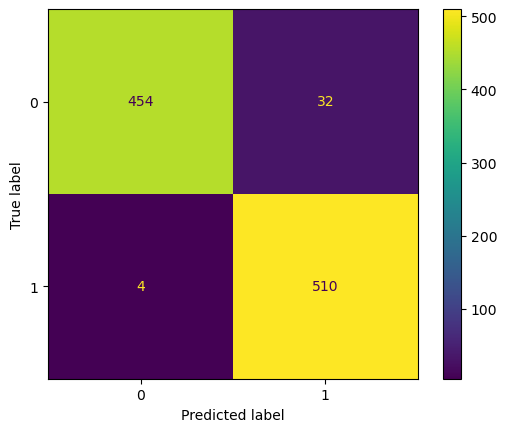

In [109]:
ConfusionMatrixDisplay.from_estimator(model_forest, synthetic_df, synthetic_true_labels)

In [110]:
synthetic_true_labels.value_counts()

1    514
0    486
Name: Label, dtype: int64

In [111]:
new_df["Label"].value_counts()

0    3773
1    3773
Name: Label, dtype: int64